In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from itertools import chain
from collections import defaultdict
from sklearn.utils import shuffle
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import  accuracy_score,classification_report, confusion_matrix  #for visualizing tree 
import scipy
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy import sparse
import pickle as cPickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Concatenate, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [65]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')


In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

!unzip -u "/content/drive/My Drive/Fake"

Mounted at /content/drive/
Archive:  /content/drive/My Drive/Fake.zip
  inflating: Fake.csv                


In [7]:

!unzip -u "/content/drive/My Drive/True"

Archive:  /content/drive/My Drive/True.zip
  inflating: True.csv                


## EDA

In [8]:
## Import fake and true news csv 

In [9]:
## False News dataset

In [10]:
fn_df=pd.read_csv("Fake.csv")
fn_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
fn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [12]:
## True News Dataset

In [13]:
tn_df=pd.read_csv("True.csv")
tn_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [14]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [15]:
fn_df['label']=0 ## fake is 0
tn_df['label']=1 ## true is 1

In [16]:
news_df=pd.concat([fn_df,tn_df],axis=0)

In [17]:
## After concatenating shuffling rows and resetting index

In [18]:
# news_df = shuffle(news_df)
news_df=news_df.sample(frac=1,random_state=23).reset_index(drop=True)

In [19]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [20]:
## total 5 column and 44898 rows

In [21]:
news_df.head()

,title,text,subject,date,label
0,"In HISTORY MAKING Kiss Cam Moment, Gay Couple...","During nearly every sporting event, at one poi...",News,"January 10, 2016",0
1,Trump advisers likely to meet again in May to ...,WASHINGTON (Reuters) - Advisers to President D...,politicsNews,"April 27, 2017",1
2,A COUGHING CLINTON Takes A Nasty Swipe At Matt...,What a bitter woman! She blames a different th...,politics,"Dec 2, 2017",0
3,Tensions lurk behind Pence's 'partnership' vis...,JAKARTA (Reuters) - Washington has billed Vice...,politicsNews,"April 13, 2017",1
4,"Ivanka Trump’s Dress Was Nice, But There Was ...",A consistent theme among Donald Trump s rhetor...,News,"March 1, 2017",0


In [22]:
## Checking for duplicated

In [23]:
news_df.duplicated().sum()

209

In [24]:
news_df[news_df.duplicated()==True]

,title,text,subject,date,label
1522,Sessions confirmed as U.S. attorney general af...,WASHINGTON (Reuters) - A bitterly divided U.S....,politicsNews,"February 9, 2017",1
3594,Highlights: The Trump presidency on April 26 a...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"April 26, 2017",1
3861,U.S. creating 'sensational hype' over China's ...,BEIJING (Reuters) - The United States has crea...,worldnews,"December 21, 2017",1
5010,"Bloomberg opts out of U.S. presidential bid, c...",WASHINGTON (Reuters) - Former New York Mayor M...,politicsNews,"March 7, 2016",1
5119,Former Trump security aide was Russia blackmai...,WASHINGTON (Reuters) - Former Acting U.S. Atto...,politicsNews,"May 8, 2017",1
...,...,...,...,...,...
44511,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",0
44659,Somali lawmakers seek to impeach president ami...,MOGADISHU (Reuters) - Some Somali lawmakers sa...,worldnews,"December 20, 2017",1
44661,Philippine police chief defends deadly drug wa...,MANILA (Reuters) - The police chief of the Phi...,worldnews,"December 20, 2017",1
44768,Highlights: The Trump presidency on April 13 a...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"April 13, 2017",1


In [25]:
## Removing duplicates

In [26]:
news_df=news_df.drop_duplicates()

In [27]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [28]:
## Checking empty rows

In [29]:
news_df = news_df.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)

In [30]:
news_df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [31]:
## No Null values

In [32]:
news_df.tail()

,title,text,subject,date,label
44893,DIAMOND AND SILK Clap-Back at Eminem: ‘When yo...,In case you haven t heard about the nasty Emin...,politics,"Oct 12, 2017",0
44894,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",0
44895,Draft Senate healthcare bill would link subsid...,WASHINGTON (Reuters) - Senate Republicans woul...,politicsNews,"June 21, 2017",1
44896,"TRUMP-HATING, Anti-Gun “COMEDIAN” And Author O...","Rabid, Trump-hating, anti-gun, comedian, and s...",politics,"Dec 7, 2017",0
44897,Trump to unveil new responses to Iranian 'bad ...,WASHINGTON (Reuters) - President Donald Trump ...,worldnews,"October 6, 2017",1


In [33]:
## After removing duplicates reset index

In [34]:
news_df.reset_index(inplace=True, drop=True)

In [35]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [36]:
##Count of subjects

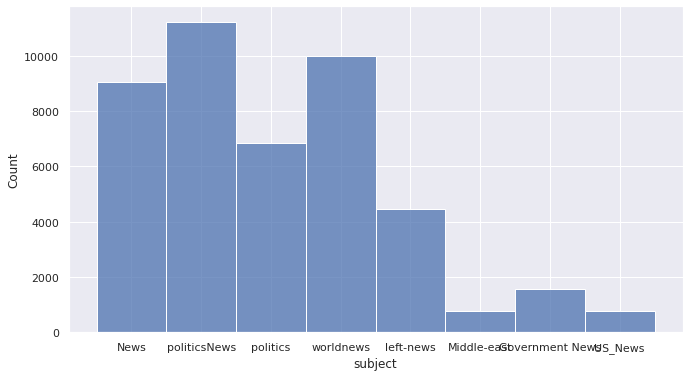

In [37]:
sns.set(rc = {'figure.figsize':(11,6)})
sns.histplot(data=news_df, x="subject")

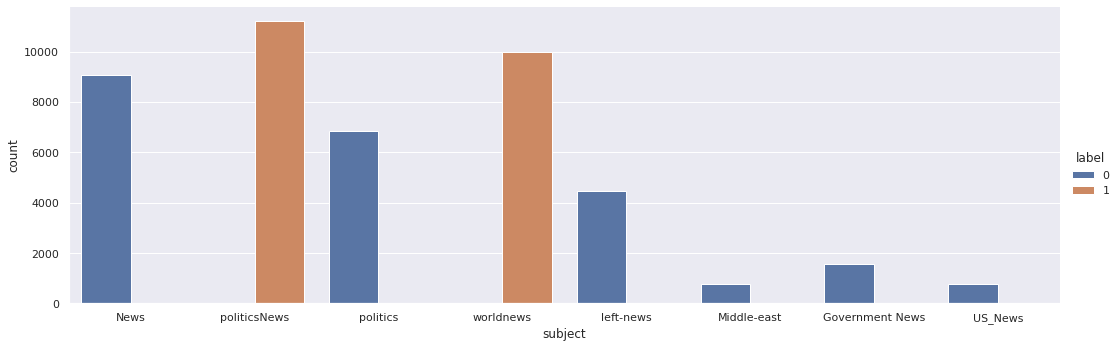

In [38]:
sns.catplot(data=news_df, kind="count",x="subject", hue="label",height=5, aspect=3);

In [39]:
news_df.groupby('subject')['label'].value_counts()

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6838
politicsNews     1        11220
worldnews        1         9991
Name: label, dtype: int64

In [40]:
## Different sujects of 2 datasets

In [41]:
news_df['subject'] = news_df['subject'].replace(['politicsNews'],'politics')

In [42]:
news_df['subject'] = news_df['subject'].replace(['worldnews'],'News')

In [43]:
## Similar subject of different datasets combines but still ambiguous

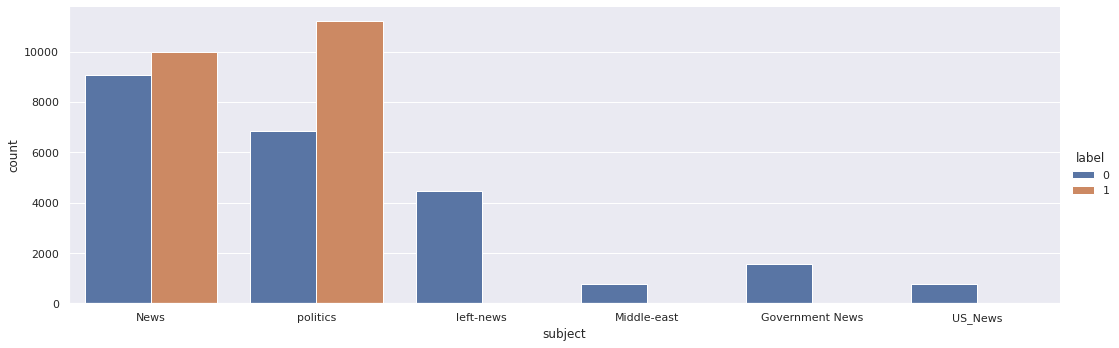

In [44]:
sns.catplot(data=news_df, kind="count",x="subject", hue="label",height=5, aspect=3);

In [45]:
## Total words in real vs fake news

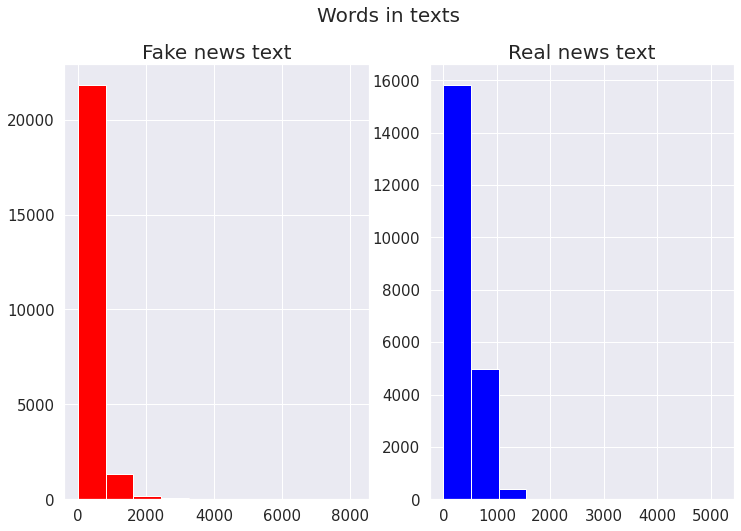

In [46]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=news_df[news_df['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.tick_params(labelsize=15)
ax1.hist(text_len,color='Red')
ax1.set_title('Fake news text',fontdict={'fontsize':20})
text_len=news_df[news_df['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.tick_params(labelsize=15)
ax2.hist(text_len,color='Blue')
ax2.set_title('Real news text',fontdict={'fontsize':20})
fig.suptitle('Words in texts',fontsize=20)
plt.show()

In [47]:
nlp=spacy.load('en_core_web_sm')

In [48]:
## Lowe case, remove digits, tokenize, remove stop words and lemmentize text

In [49]:
news_df_cp=news_df.copy()

In [50]:
news_df_cp=news_df_cp.sample(20000,random_state=42)

In [51]:
## Applying function on both text and title columns

In [52]:

def preprocess(text):
    text = text.lower()
    text = ''.join(c for c in text if not c.isdigit()) #remove digits.
    stop_words = stopwords.words('english') # removes words which has less meaning 
    text = ' '.join([w for w in nltk.word_tokenize(text) if not w in stop_words])
    wordnet_lemmatizer = WordNetLemmatizer() # with use of morphological analysis of words
    text = [wordnet_lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
    text = " ".join(w for w in text)
    return text

In [63]:
news_df_cp["title"]=news_df_cp["title"].apply(preprocess)

In [64]:
news_df_cp['text']=news_df_cp['text'].apply(preprocess)

In [66]:
text = [str(doc) for doc in nlp.pipe(news_df_cp['text'], batch_size=100)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(news_df_cp['title'], batch_size=100)]

In [67]:
title = [str(doc) for doc in nlp.pipe(news_df_cp['title'], batch_size=100)]

In [68]:
title[0]

"uk lawmaker back government 's proposed timetable debate eu withdrawal bill"

In [69]:
text[0] 


'london ( reuters ) - british lawmaker tuesday voted favor government proposed timetable debating legislation designed sever political , financial legal tie european union . many complained eight day set government line-by-line scrutiny eu withdrawal bill long enough important piece legislation . lawmaker voted support so-called program motion , set timetable remaining stage bill progress parliament lower house common .'

In [70]:
summary[0]

"_START_ uk lawmaker back government 's proposed timetable debate eu withdrawal bill _END_"

In [71]:
news_summ_df=pd.DataFrame({"text":[],"summary":[]})

In [72]:

news_summ_df['text'] = pd.Series(text)
news_summ_df['summary'] = pd.Series(summary)

In [73]:
news_summ_df

,text,summary
0,london ( reuters ) - british lawmaker tuesday ...,_START_ uk lawmaker back government 's propose...
1,st century wire say week u presidential execut...,"_START_ open society : soros-backed , anti-tru..."
2,,_START_ julian assange reveals john podesta ’ ...
3,term fake news become attached america major n...,_START_ boom ! indiana ymca take cnn tv ’ memb...
4,sen. john mccain ( r-ariz. ) dug hole meet pre...,_START_ mccain need go ! make claim trump tryi...
...,...,...
19995,also said current u administration merely fini...,_START_ trump accelerating decline u global in...
19996,dublin ( reuters ) - deal propping irish gover...,_START_ irish pm 's party say government deal ...
19997,supreme court justice antonin scalia still dea...,_START_ bush attorney general : obama ‘ obliga...
19998,"st century wire say robert parry , best known ...",_START_ trump ’ ‘ wag dog ’ moment _END_


In [74]:
news_summ_df = news_summ_df.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)

In [75]:
news_summ_df.isnull().sum()

text       267
summary      0
dtype: int64

In [76]:
news_summ_df_cp=news_summ_df.dropna(axis=0)

In [77]:
news_summ_df_cp=news_summ_df_cp.reset_index(drop=True)

In [78]:
news_summ_df_cp.isnull().sum()

text       0
summary    0
dtype: int64

In [79]:
news_summ_df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19733 entries, 0 to 19732
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     19733 non-null  object
 1   summary  19733 non-null  object
dtypes: object(2)
memory usage: 308.5+ KB


In [80]:
news_summ_df_cp.to_csv("news_summ_df.csv")

In [4]:
news_summ_df=pd.read_csv('news_summ_df.csv',index_col=[0]).reset_index(drop=True)

In [5]:
news_summ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4997 entries, 0 to 4996
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     4997 non-null   object
 1   summary  4997 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [6]:
# news_summ_df=news_summ_df.sample(5000,random_state=42)

In [7]:
news_summ_df=news_summ_df.reset_index(drop=True)

In [8]:
news_summ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4997 entries, 0 to 4996
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     4997 non-null   object
 1   summary  4997 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


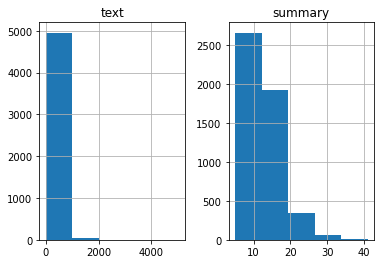

In [9]:

text_count = []
summary_count = []

for sent in news_summ_df['text']:
    text_count.append(len(sent.split()))
    
for sent in news_summ_df['summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [10]:
count = 0
for i in  news_summ_df['text']:
    if len(i.split()) <= 500:
        count = count + 1
print(count / len(news_summ_df['text']))

0.8961376826095657


In [11]:
max_text_len = 500
max_summary_len = 20

In [12]:
text = np.array(news_summ_df['text'])
summary= np.array(news_summ_df['summary'])

short_text = []
short_summary = []

for i in range(len(text)):
    if len(summary[i].split()) <= max_summary_len and len(text[i].split()) <= max_text_len:
        short_text.append(text[i])
        short_summary.append(summary[i])
        
news_summ = pd.DataFrame({'text': short_text,'summary': short_summary})

news_summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     4186 non-null   object
 1   summary  4186 non-null   object
dtypes: object(2)
memory usage: 65.5+ KB


In [13]:
# news_summ['summary'] = news_summ['summary'].apply(lambda x: 'sostok ' + x \
#         + ' eostok')

# news_summ.head(2)

In [14]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(news_summ["text"]),
    np.array(news_summ["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [15]:
y_tr

array(['_START_ donald trump tweet ready hand putin key electoral system _END_',
       '_START_ east timor president say swear mari alkatiri pm _END_',
       '_START_ trump back alabama republican senate candidate moore _END_',
       ...,
       "_START_ north korea meeting seek 'better idea ' solve crisis : canada _END_",
       '_START_ court decision shift abortion battle state ban _END_',
       '_START_ rnc staffer assigned finding positive story trump say take job shove _END_'],
      dtype=object)

In [16]:
# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [17]:
thresh = 2

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  38.11759584590032


In [18]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 19903


In [19]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 2

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
print(y_tr_seq,"tr_seq")
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
print(y_tr,"tr")
# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 49.70651395848246
[[2, 35, 3, 31, 517, 401, 121, 440, 1068, 518, 1], [2, 441, 19, 9, 84, 1], [2, 3, 72, 636, 18, 33, 144, 726, 1], [2, 1230, 727, 1069, 1489, 2424, 212, 442, 1837, 35, 3, 1], [2, 637, 2425, 49, 43, 402, 125, 178, 58, 2426, 1490, 164, 5, 1], [2, 16, 151, 93, 519, 821, 1491, 243, 4, 145, 3, 5, 1], [2, 520, 638, 283, 1492, 403, 1231, 404, 4, 579, 344, 1], [2, 65, 405, 46, 639, 370, 244, 640, 1493, 927, 1070, 5, 1], [2, 1494, 521, 10, 345, 928, 4, 641, 728, 1071, 729, 5, 1], [2, 6, 7, 234, 213, 235, 443, 346, 4, 1838, 2427, 1839, 4, 283, 1], [2, 522, 1495, 10, 315, 3, 4, 214, 146, 1], [2, 245, 84, 55, 1496, 1232, 2428, 95, 261, 1], [2, 1497, 203, 2429, 1498, 22, 8, 1499, 1233, 1], [2, 83, 4, 929, 822, 222, 823, 3, 1500, 10, 1234, 4, 1501, 371, 5, 1], [2, 132, 2430, 1502, 4, 246, 56, 158, 43, 5, 1], [2, 159, 642, 3, 316, 112, 1840, 1841, 1], [2, 1503, 27, 23, 284, 10, 1072, 4, 5, 1], [2, 478, 41, 2431, 2432, 2433, 191, 1], [2, 223, 1504, 113, 5

In [20]:
def remove_empty_summ(x_seq,y_seq):
   ind = []
   for i in range(len(y_seq)):
      cnt = 0
      for j in y_seq[i]:
         if j != 0:        
            cnt = cnt + 1
      if cnt == 2:
         print(j,"j",y_seq[i])
         ind.append(i)
   print(ind)
   y_seq = np.delete(y_seq, ind, axis=0)
   x_seq = np.delete(x_seq, ind, axis=0)
   return x_seq,y_seq

In [21]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
x_tr, y_tr=remove_empty_summ(x_tr,y_tr)

[]


In [22]:
len(y_tr)

3767

In [23]:
x_val, y_val=remove_empty_summ(x_val,y_val)

[]


In [24]:
latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     1990300     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [134]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v4.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [135]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')



In [136]:
news_summ_df

,text,summary
0,leftist activist mediocre filmmaker michael mo...,"_START_ donald trump jr. , humiliated michael ..."
1,meme spread around :,_START_ sick lie cnn ? ’ luck ! today turn cnn...
2,marco rubio may come third iowa caucus behind ...,_START_ rubio copied one obama ’ famous speech...
3,first time scientist caught manipulating evide...,_START_ high-level whistleblower expose astoni...
4,"early sunday morning , omar mateen walked gay ...",_START_ conservative desperately turn social m...
...,...,...
4992,washington ( reuters ) - u.s. voting right adv...,"_START_ winning court , losing ground : uncert..."
4993,washington ( reuters ) - top u.s. derivative r...,_START_ cftc poised lose sole democratic commi...
4994,normally mild mannered george takei pissed gun...,_START_ george takei ready wage war nra _END_
4995,"sittwe , myanmar ( reuters ) - relief agency s...",_START_ buddhist mistrust foreign aid worker h...


In [141]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=10,
    callbacks=[tl_checkpoint_1,es],
    batch_size=48,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 3.6986 
Epoch 1: val_loss improved from inf to 3.18192, saving model to tl_model_v4.weights.best.hdf5
79/79 [==============================] - 1931s 24s/step - loss: 3.6986 - val_loss: 3.1819
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 3.3963 
Epoch 2: val_loss improved from 3.18192 to 3.07912, saving model to tl_model_v4.weights.best.hdf5
79/79 [==============================] - 1980s 25s/step - loss: 3.3963 - val_loss: 3.0791
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 3.3145 
Epoch 3: val_loss improved from 3.07912 to 3.03734, saving model to tl_model_v4.weights.best.hdf5
79/79 [==============================] - 1963s 25s/step - loss: 3.3145 - val_loss: 3.0373
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 3.2578 
Epoch 4: val_loss improved from 3.03734 to 3.01617, saving model to tl_model_v4.weights.best.hdf5
79/79 [==============================]

In [142]:
from google.colab import files
files.download('/content/tl_model_v4.weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
!cp /content/tl_model_v4.weights.best.hdf5 /content/drive/MyDrive/models/

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [137]:
tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v5.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [138]:
loaded_model = load_model('/content/drive/MyDrive/models/tl_model_v4.weights.best.hdf5')
new_history = loaded_model.fit( [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=5,
    callbacks=[tl_checkpoint_2,es],
    batch_size=48,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
                    )


Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 2.9789 
Epoch 1: val_loss improved from inf to 2.95698, saving model to tl_model_v5.weights.best.hdf5
79/79 [==============================] - 2066s 25s/step - loss: 2.9789 - val_loss: 2.9570
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 2.9383 
Epoch 2: val_loss improved from 2.95698 to 2.95528, saving model to tl_model_v5.weights.best.hdf5
79/79 [==============================] - 1985s 25s/step - loss: 2.9383 - val_loss: 2.9553
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 2.8984 
Epoch 3: val_loss improved from 2.95528 to 2.95464, saving model to tl_model_v5.weights.best.hdf5
79/79 [==============================] - 1984s 25s/step - loss: 2.8984 - val_loss: 2.9546
Epoch 4/5
79/79 [==============================] - ETA: 0s - loss: 2.8567 
Epoch 4: val_loss did not improve from 2.95464
79/79 [==============================] - 1966s 25s/step - loss: 2.8567 - val_loss: 2.9611
Epo

In [139]:
!cp /content/tl_model_v5.weights.best.hdf5 /content/drive/MyDrive/models/

In [3]:
loaded_model_v5= load_model('/content/drive/MyDrive/models/tl_model_v5.weights.best.hdf5')

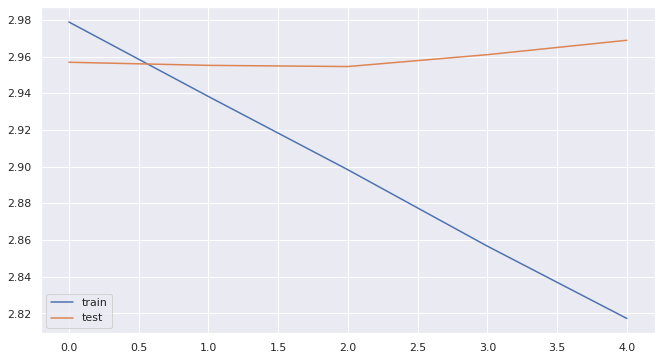

In [140]:
from matplotlib import pyplot

pyplot.plot(new_history.history['loss'], label='train')
pyplot.plot(new_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [31]:
reverse_source_word_index

{1: 'said',
 2: 'trump',
 3: 'u',
 4: '’',
 5: 'state',
 6: 'president',
 7: 'would',
 8: 's',
 9: '“',
 10: '”',
 11: 'people',
 12: 'year',
 13: 'republican',
 14: 'one',
 15: 'reuters',
 16: 'donald',
 17: 'new',
 18: 'also',
 19: 'government',
 20: 'house',
 21: 'time',
 22: 'election',
 23: 'clinton',
 24: 'party',
 25: 'say',
 26: 'obama',
 27: 'right',
 28: 'american',
 29: 'country',
 30: 'told',
 31: 'like',
 32: 'two',
 33: 'united',
 34: 'could',
 35: 'campaign',
 36: 'white',
 37: 'last',
 38: 'law',
 39: 'news',
 40: 'first',
 41: 'official',
 42: 'image',
 43: 'washington',
 44: 'week',
 45: 'make',
 46: 'even',
 47: 'day',
 48: 'get',
 49: 'court',
 50: 'group',
 51: 'woman',
 52: 'vote',
 53: 'hillary',
 54: 'bill',
 55: 'via',
 56: 'former',
 57: 'want',
 58: 'may',
 59: 'know',
 60: 'democrat',
 61: 'leader',
 62: 'twitter',
 63: 'presidential',
 64: 'many',
 65: 'made',
 66: 'security',
 67: 'the',
 68: 'since',
 69: 'month',
 70: 'political',
 71: 'national',
 72: '

In [32]:
reverse_target_word_index

{1: 'end',
 2: 'start',
 3: 'trump',
 4: '’',
 5: 'video',
 6: 'u',
 7: 's',
 8: "'s",
 9: 'say',
 10: '‘',
 11: 'obama',
 12: '”',
 13: '“',
 14: "'",
 15: 'house',
 16: 'watch',
 17: 'hillary',
 18: 'republican',
 19: 'president',
 20: 'new',
 21: 'white',
 22: 'state',
 23: 'clinton',
 24: 'bill',
 25: 'russia',
 26: 'election',
 27: 'call',
 28: 'vote',
 29: 'north',
 30: 'court',
 31: 'tweet',
 32: 'democrat',
 33: 'senate',
 34: 'korea',
 35: 'donald',
 36: 'make',
 37: '–',
 38: 'china',
 39: 'go',
 40: 'plan',
 41: 'police',
 42: 'tax',
 43: 'leader',
 44: 'gop',
 45: 'get',
 46: 'woman',
 47: 'want',
 48: 'deal',
 49: 'party',
 50: 'black',
 51: 'right',
 52: 'iran',
 53: 'talk',
 54: 'attack',
 55: 'may',
 56: 'one',
 57: 'campaign',
 58: 'eu',
 59: 'senator',
 60: 'government',
 61: 'american',
 62: 'show',
 63: 'minister',
 64: 'tell',
 65: 'muslim',
 66: 'russian',
 67: 'report',
 68: 'news',
 69: 'medium',
 70: 'anti',
 71: 'year',
 72: 'back',
 73: 'america',
 74: 'law',

In [33]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [34]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'end' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [35]:
target_word_index['start']

2

In [36]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['start'] and i \
            != target_word_index['end']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [38]:
from nltk.translate.bleu_score import corpus_bleu


In [37]:
for i in range(0, 3):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1, max_text_len)))
    ## taking both review and original summ as reference
    print('\n')

Review: donald trump tweeted sunday morning visit russian president vladimir putin standard complaining medium trying bolster controversial meeting russian strongman one particular stood according trump ready partner yes partner cyber security joke i strongly pressed president putin twice russian meddling election vehemently denied already given opinion donald j trump realdonaldtrump july um sure negotiated ceasefire part syria save life time move forward working russia donald j trump realdonaldtrump july notable tweet though one essentially said giving fox key hen house putin discussed forming impenetrable cyber security unit election hacking many negative thing guarded donald j trump realdonaldtrump july deflection safe question asked cia fbi ask dnc time server rejected still donald j trump realdonaldtrump july fake news said intel agency actually apologize obama nothing info election donald j trump realdonaldtrump july irony partnering putin securing electoral system accused hackin

In [148]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 500, 100)     1990300     ['input_5[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 500, 300),   481200      ['embedding_4[0][0]']            
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                            

In [43]:
cPickle.dump(loaded_model, open("model_news_summ", 'wb'))

In [46]:
import random
randomlist = []
for i in range(0,10):
  n = random.randint(1,900)
  randomlist.append(n)
print(randomlist)

[825, 817, 641, 386, 274, 37, 269, 786, 485, 454]


In [ ]:
 print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1, max_text_len)))

In [41]:
 seq2text(x_tr[0])

'donald trump tweeted sunday morning visit russian president vladimir putin standard complaining medium trying bolster controversial meeting russian strongman one particular stood according trump ready partner yes partner cyber security joke i strongly pressed president putin twice russian meddling election vehemently denied already given opinion donald j trump realdonaldtrump july um sure negotiated ceasefire part syria save life time move forward working russia donald j trump realdonaldtrump july notable tweet though one essentially said giving fox key hen house putin discussed forming impenetrable cyber security unit election hacking many negative thing guarded donald j trump realdonaldtrump july deflection safe question asked cia fbi ask dnc time server rejected still donald j trump realdonaldtrump july fake news said intel agency actually apologize obama nothing info election donald j trump realdonaldtrump july irony partnering putin securing electoral system accused hacking even 

In [47]:
scores=[]
for i in randomlist:
      reference = [[seq2text(x_tr[i]).split(" "),seq2summary(y_tr[i]).split(" ")]]
      candidate = [decode_sequence(x_tr[i].reshape(1, max_text_len)).split(' ')]
      score = corpus_bleu(reference, candidate)
      scores.append(score)

1/1 [==============================] - 0s 22ms/step


In [48]:
scores

[8.614911585158347e-232,
 8.614911585158347e-232,
 8.614911585158347e-232,
 8.614911585158347e-232,
 1.0244914152188952e-231,
 1.0244914152188952e-231,
 8.614911585158347e-232,
 1.0244914152188952e-231,
 6.070825588040848e-232,
 8.614911585158347e-232]